<a href="https://colab.research.google.com/github/aliakbarbadri/natural-language-inference/blob/master/snli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import unicodedata
import re
import matplotlib.pyplot as plt
import pandas as pd
import os
import imageio

# Load and preprocess the data

In [2]:
BATCH_SIZE = 64

In [3]:
source = pd.read_pickle(r'https://github.com/aliakbarbadri/natural-language-inference/blob/master/premises_train.pickle?raw=true')
target = pd.read_pickle(r'https://github.com/aliakbarbadri/natural-language-inference/blob/master/hypotheses_train.pickle?raw=true')

In [4]:
print(source[0])
print(target[0])

A person on a horse jumps over a broken down airplane .
A person is outdoors , on a horse .


In [5]:
src = source[:50000]
trg = target[:50000]

In [6]:
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalize_string(s):
    s = unicode_to_ascii(s)
    s = re.sub(r'([!.?])', r' \1', s)
    s = re.sub(r'[^a-zA-Z.!?]+', r' ', s)
    s = re.sub(r'\s+', r' ', s)
    return s

In [7]:
raw_data_src = [normalize_string(data) for data in src]
raw_data_trg_in = ['<start> ' + normalize_string(data) for data in trg]
raw_data_trg_out = [normalize_string(data) + ' <end>' for data in trg]

In [8]:
src_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
src_tokenizer.fit_on_texts(raw_data_src)
data_src = src_tokenizer.texts_to_sequences(raw_data_src)
data_src = tf.keras.preprocessing.sequence.pad_sequences(data_src,
                                                        padding='post')
print(data_src[:2])

[[   1   55    6    1  212  206   68    1 1593   40  782    2    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]
 [  58  140    5 1115   18  100    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]]


In [9]:
trg_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
trg_tokenizer.fit_on_texts(raw_data_trg_in)
trg_tokenizer.fit_on_texts(raw_data_trg_out)
data_trg_in = trg_tokenizer.texts_to_sequences(raw_data_trg_in)
data_trg_in = tf.keras.preprocessing.sequence.pad_sequences(data_trg_in,
                                                           padding='post')
print(data_trg_in[:2])

data_trg_out = trg_tokenizer.texts_to_sequences(raw_data_trg_out)
data_trg_out = tf.keras.preprocessing.sequence.pad_sequences(data_trg_out,
                                                            padding='post')
print(data_trg_out[:2])

[[  3   1  19   5  34  11   1 163   2   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  3  15   7  44 454   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]]
[[  1  19   5  34  11   1 163   2   4   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [ 15   7  44 454   4   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]]


In [10]:
dataset = tf.data.Dataset.from_tensor_slices(
    (data_src, data_trg_in, data_trg_out))
dataset = dataset.shuffle(len(raw_data_src)).batch(
    BATCH_SIZE, drop_remainder=True)

# Model

In [25]:
MODE = 'train'
EMBEDDING_SIZE = 256
RNN_SIZE = 512
NUM_EPOCHS = 40

In [26]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_size, rnn_size):
    super(Encoder, self).__init__()
    self.rnn_size = rnn_size
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
    self.lstm = tf.keras.layers.LSTM(rnn_size, return_sequences=True, return_state=True)
  def call(self, sequence, states):
    embed = self.embedding(sequence)
    output, state_h, state_c = self.lstm(embed, initial_state=states)
    return output, state_h, state_c
  def init_states(self, batch_size):
    return (tf.zeros([batch_size, self.rnn_size]),
    tf.zeros([batch_size, self.rnn_size]))

src_vocab_size = len(src_tokenizer.word_index) + 1
encoder = Encoder(src_vocab_size, EMBEDDING_SIZE, RNN_SIZE)
initial_state = encoder.init_states(1)

In [27]:
class LuongAttention(tf.keras.Model):
  def __init__(self, rnn_size):
    super(LuongAttention, self).__init__()
    # Concat score function
    self.wa = tf.keras.layers.Dense(rnn_size, activation='tanh')
    self.va = tf.keras.layers.Dense(1)
  def call(self, decoder_output, encoder_output):
    # Concat score function: va (dot) tanh(Wa (dot) concat(decoder_output + encoder_output))
    # Decoder output must be broadcasted to encoder output's shape first
    decoder_output = tf.tile(
    decoder_output, [1, encoder_output.shape[1], 1])
    # Concat => Wa => va
    # (batch_size, max_len, 2 * rnn_size) => (batch_size, max_len, rnn_size) => (batch_size, max_len, 1)
    score = self.va(self.wa(tf.concat((decoder_output, encoder_output), axis=-1)))
    # Transpose score vector to have the same shape as other two above
    # (batch_size, max_len, 1) => (batch_size, 1, max_len)
    score = tf.transpose(score, [0, 2, 1])
    # alignment a_t = softmax(score)
    alignment = tf.nn.softmax(score, axis=2)
    # context vector c_t is the weighted average sum of encoder output
    context = tf.matmul(alignment, encoder_output)
    return context, alignment

In [28]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_size, rnn_size):
    super(Decoder, self).__init__()
    self.attention = LuongAttention(rnn_size)
    self.rnn_size = rnn_size
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
    self.lstm = tf.keras.layers.LSTM(
    rnn_size, return_sequences=True, return_state=True)
    self.wc = tf.keras.layers.Dense(rnn_size, activation='tanh')
    self.ws = tf.keras.layers.Dense(vocab_size)
  def call(self, sequence, state, encoder_output):
    # Remember that the input to the decoder
    # is now a batch of one-word sequences,
    # which means that its shape is (batch_size, 1)
    embed = self.embedding(sequence)
    # Therefore, the lstm_out has shape (batch_size, 1, rnn_size)
    lstm_out, state_h, state_c = self.lstm(embed, initial_state=state)
    # Use self.attention to compute the context and alignment vectors
    # context vector's shape: (batch_size, 1, rnn_size)
    # alignment vector's shape: (batch_size, 1, source_length)
    context, alignment = self.attention(lstm_out, encoder_output)
    # Combine the context vector and the LSTM output
    # Before combined, both have shape of (batch_size, 1, rnn_size),
    # so let's squeeze the axis 1 first
    # After combined, it will have shape of (batch_size, 2 * rnn_size)
    lstm_out = tf.concat(
                [tf.squeeze(context, 1), tf.squeeze(lstm_out, 1)], 1)
    # lstm_out now has shape (batch_size, rnn_size)
    lstm_out = self.wc(lstm_out)
    # Finally, it is converted back to vocabulary space: (batch_size, vocab_size)
    logits = self.ws(lstm_out)
    return logits, state_h, state_c, alignment


trg_vocab_size = len(trg_tokenizer.word_index) + 1
decoder = Decoder(trg_vocab_size, EMBEDDING_SIZE, RNN_SIZE)

In [29]:
def loss_func(targets, logits):
  crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  mask = tf.math.logical_not(tf.math.equal(targets, 0))
  mask = tf.cast(mask, dtype=tf.int64)
  loss = crossentropy(targets, logits, sample_weight=mask)
  return loss

optimizer = tf.keras.optimizers.RMSprop()

In [30]:
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

In [31]:
@tf.function
def train_step(source_seq, target_seq_in, target_seq_out, en_initial_states):
  loss = 0
  acc = 0
  with tf.GradientTape() as tape:
    en_outputs = encoder(source_seq, en_initial_states)
    en_states = en_outputs[1:]
    de_state_h, de_state_c = en_states
    
    # We need to create a loop to iterate through the target sequences
    for i in range(target_seq_out.shape[1]):
      # Input to the decoder must have shape of (batch_size, length)
      # so we need to expand one dimension
      decoder_in = tf.expand_dims(target_seq_in[:, i], 1)
      logit, de_state_h, de_state_c, _ = decoder(
      decoder_in, (de_state_h, de_state_c), en_outputs[0])

      # The loss is now accumulated through the whole batch
      loss += loss_func(target_seq_out[:, i], logit)
      accuracy.update_state(target_seq_out[:, i], logit)
      # acc += acc_func(target_seq_out[:, i], logit)
  # print("acc",)
  # print(acc / target_seq_out.shape[1])
  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))
  return loss / target_seq_out.shape[1], accuracy.result()

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
! rm -rf ./checkpoints
! mkdir ./checkpoints
! mkdir checkpoints/encoder
! mkdir checkpoints/decoder

In [34]:
! ls checkpoints/decoder

In [35]:
# train_dataset, test_dataset = train_test_split(dataset,test_size=0.2)
# dataset.take(-1)
all_loss = []
all_acc = []

In [36]:
if MODE == 'train':
  loss_list = []
  acc_list = []
  for e in range(10):
    en_initial_states = encoder.init_states(BATCH_SIZE)
    encoder.save_weights('checkpoints/encoder/encoder_{}.h5'.format(e + 1))
    decoder.save_weights('checkpoints/decoder/decoder_{}.h5'.format(e + 1))
    loss = 0
    acc = 0
    counter = 0
    for batch, (source_seq, target_seq_in, target_seq_out) in enumerate(dataset.take(-1)):
      batch_loss, acc = train_step(source_seq, target_seq_in,target_seq_out, en_initial_states)
      loss += batch_loss.numpy()
      counter += 1
      if batch % 100 == 0:
        print('Epoch {}, Batch {}, Loss {:.4f} , Acc {:.4f}'.format(e + 1, batch, batch_loss.numpy(), acc.numpy()))

    print('Epoch {}, Loss {:.4f} , Acc {:.4f}'.format(e + 1, loss/counter, acc.numpy()))
    loss_list.append(loss/counter)
    acc_list.append(acc.numpy())
    print()
  all_loss.append(loss_list)
  all_acc.append(acc_list)

Epoch 1, Batch 0, Loss 1.6689 , Acc 0.0000
Epoch 1, Batch 100, Loss 0.7521 , Acc 0.0512
Epoch 1, Batch 200, Loss 0.7123 , Acc 0.0613
Epoch 1, Batch 300, Loss 0.6600 , Acc 0.0665
Epoch 1, Batch 400, Loss 0.5150 , Acc 0.0707
Epoch 1, Batch 500, Loss 0.6349 , Acc 0.0734
Epoch 1, Batch 600, Loss 0.5659 , Acc 0.0756
Epoch 1, Batch 700, Loss 0.5920 , Acc 0.0773
Epoch 1, Loss 0.6569 , Acc 0.0784

Epoch 2, Batch 0, Loss 0.5441 , Acc 0.0784
Epoch 2, Batch 100, Loss 0.6167 , Acc 0.0797
Epoch 2, Batch 200, Loss 0.6336 , Acc 0.0809
Epoch 2, Batch 300, Loss 0.4337 , Acc 0.0820
Epoch 2, Batch 400, Loss 0.5257 , Acc 0.0830
Epoch 2, Batch 500, Loss 0.4519 , Acc 0.0839
Epoch 2, Batch 600, Loss 0.4805 , Acc 0.0848
Epoch 2, Batch 700, Loss 0.4986 , Acc 0.0856
Epoch 2, Loss 0.5341 , Acc 0.0863

Epoch 3, Batch 0, Loss 0.4310 , Acc 0.0863
Epoch 3, Batch 100, Loss 0.5580 , Acc 0.0870
Epoch 3, Batch 200, Loss 0.4813 , Acc 0.0878
Epoch 3, Batch 300, Loss 0.4873 , Acc 0.0885
Epoch 3, Batch 400, Loss 0.4735 , Ac

In [37]:
all_loss

[[0.656902540851952,
  0.5341033801989732,
  0.4816383744629336,
  0.4470475309942199,
  0.4201852660936216,
  0.39655574198416343,
  0.3750998747562477,
  0.35663822484077473,
  0.34100240923073166,
  0.3265157805209581]]

In [38]:
all_acc

[[0.07843419,
  0.08627511,
  0.09122889,
  0.09477078,
  0.09756586,
  0.09996214,
  0.10212781,
  0.10418556,
  0.10618292,
  0.1081537]]

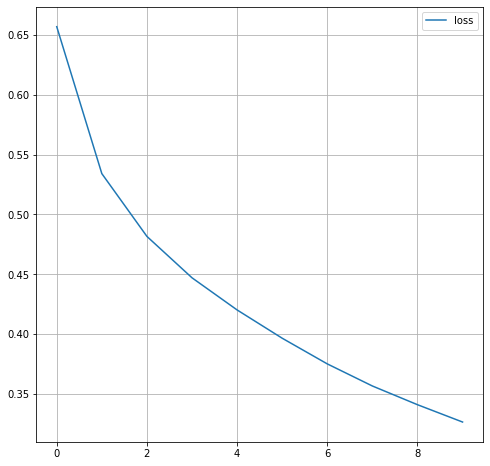

In [39]:
pd.DataFrame({'loss':np.array(all_loss).flatten(),
              # 'valid_loss':history.history['val_loss'],
              }).plot(figsize=(8, 8))
plt.grid(True)

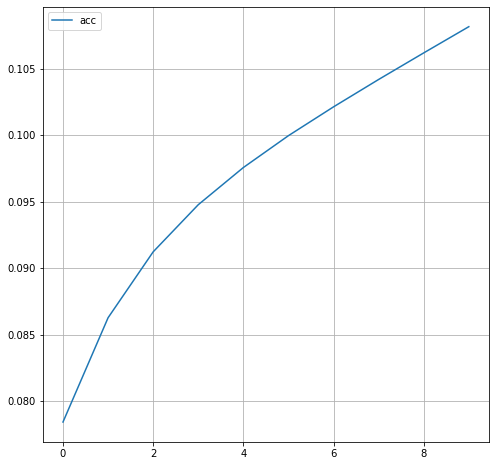

In [40]:
pd.DataFrame({'acc':np.array(acc_list).flatten(),
              # 'valid_loss':history.history['val_loss'],
              }).plot(figsize=(8, 8))
plt.grid(True)

In [41]:
! rm -rf "/content/drive/My Drive/nn/checkpoints/"
! cp -r checkpoints "/content/drive/My Drive/nn/"

# Infrence

In [42]:
! ls "/content/drive/My Drive/nn/checkpoints/encoder"

encoder_10.h5  encoder_2.h5  encoder_4.h5  encoder_6.h5  encoder_8.h5
encoder_1.h5   encoder_3.h5  encoder_5.h5  encoder_7.h5  encoder_9.h5


In [ ]:
encoder.load_weights("/content/drive/My Drive/nn/checkpoints/encoder/encoder_20.h5")
decoder.load_weights("/content/drive/My Drive/nn/checkpoints/decoder/decoder_20.h5")

In [43]:
def predict(test_source_text=None):
  if test_source_text is None:
    test_source_text = raw_data_en[np.random.choice(len(raw_data_en))]
    print(test_source_text)
  test_source_seq = src_tokenizer.texts_to_sequences([test_source_text])
  # print(test_source_seq)
  
  en_initial_states = encoder.init_states(1)
  en_outputs = encoder(tf.constant(test_source_seq), en_initial_states)
  
  de_input = tf.constant([[trg_tokenizer.word_index['<start>']]])
  de_state_h, de_state_c = en_outputs[1:]
  out_words = []
  alignments = []
  
  while True:
    de_output, de_state_h, de_state_c, alignment = decoder(de_input, (de_state_h, de_state_c), en_outputs[0])
    de_input = tf.expand_dims(tf.argmax(de_output, -1), 0)
    out_words.append(trg_tokenizer.index_word[de_input.numpy()[0][0]])
    alignments.append(alignment.numpy())
    
    if out_words[-1] == '<end>' or len(out_words) >= 20:
      break
  return np.array(alignments), test_source_text.split(' '), out_words

In [44]:
inp = pd.read_pickle(r'https://github.com/aliakbarbadri/natural-language-inference/blob/master/premises_train.pickle?raw=true')
outp = pd.read_pickle(r'https://github.com/aliakbarbadri/natural-language-inference/blob/master/hypotheses_train.pickle?raw=true')

In [45]:
test_src_sents = inp[-5:]
test_trg_sents = outp[-5:]

In [46]:
len(test_src_sents),test_src_sents[0]

(5, 'A group of four kids stand in front of a statue of a large animal .')

In [47]:
! rm -rf heatmap/
! mkdir heatmap
filenames = []
for i, test_sent in enumerate(test_src_sents):
  
  test_sequence = normalize_string(test_sent)
  alignments, source, prediction = predict(test_sequence)
  print("input:",test_sent)
  print("actual:",test_trg_sents[i])
  print("predicted:",' '.join(prediction)[:-6])
  print("---------")
  attention = np.squeeze(alignments, (1, 2))
  fig = plt.figure(figsize=(10, 10))
  fig.show()
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='jet')
  ax.set_xticklabels([''] + source, rotation=90)
  ax.set_yticklabels([''] + prediction)
  filenames.append('heatmap/test_{}.png'.format(i))
  plt.savefig('heatmap/test_{}.png'.format(i))
  plt.close()

input: A group of four kids stand in front of a statue of a large animal .
actual: four kids standing
predicted: a group of kids are standing by a large large large large large large large animal .
---------
input: a kid doing tricks on a skateboard on a bridge
actual: a kid is skateboarding
predicted: does a trick on a skateboard
---------
input: A dog with a blue collar plays ball outside .
actual: a dog is outside
predicted: a dog is playing outside .
---------
input: Four dirty and barefooted children .
actual: four children have dirty feet .
predicted: children are playing on a four four people are around a game .
---------
input: A man is surfing in a bodysuit in beautiful blue water .
actual: On the beautiful blue water there is a man in a bodysuit surfing .
predicted: a man in a boat .
---------


In [48]:
! rm -rf "/content/drive/My Drive/nn/heatmap/"
! cp -r heatmap "/content/drive/My Drive/nn/"

# BLEU

In [49]:
! pip install -q nltk

In [50]:
X_test = inp[-1000:]
y_test = outp[-1000:]

In [51]:
len(X_test),len(y_test)

(1000, 1000)

In [52]:
list_of_references = []
list_of_hypotheses = []

for i, test_sent in enumerate(X_test):
  
  test_sequence = normalize_string(test_sent)
  alignments, source, prediction = predict(test_sequence)
  list_of_references.append([y_test[i].split()[:-1]])
  list_of_hypotheses.append(prediction[:-1])
  # print("input:",test_sent)
  # print("actual:",test_trg_sents[i])
  # print("predicted:",' '.join(prediction)[:-6])
  # print("---------")

In [53]:
list_of_references[0]

[['A', 'group', 'of', 'four', 'are', 'sitting', 'on', 'the', 'sidewalk']]

In [54]:
list_of_hypotheses[0]

['people', 'sitting', 'down', 'a', 'sidewalk', '.']

In [55]:
import nltk
import warnings
warnings.filterwarnings('ignore')
nltk.bleu_score.corpus_bleu(list_of_references, list_of_hypotheses)

0.06281239370136549

In [56]:
from nltk.translate.bleu_score import corpus_bleu

print('BLEU-1: %f' % corpus_bleu(list_of_references, list_of_hypotheses, weights=(1.0, 0, 0, 0)))

BLEU-1: 0.277384
